# 项目：电影数据集探索

## 目录
<ul>
<li><a href="#intro">简介</a></li>
<li><a href="#wrangling">数据整理</a></li>
<li><a href="#eda">探索性数据分析</a></li>
<li><a href="#conclusions">结论</a></li>
</ul>

<a id='intro'></a>
## 简介

> 电影数据集中包含 1 万多条电影信息，信息来源为“电影数据库”（TMDb，The Movie Database），包括用户评分和票房。“演职人员 (cast)”、“电影类别 (genres)”等数据列。

In [15]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<a id='wrangling'></a>
## 数据整理

> **提示**：在报告的这一部分中载入数据，检查简洁度，然后整理和清理数据集，以便进行分析。请务必将步骤仔细归档，并确定清理决策是否正确。

### 常规属性

In [70]:
# 加载数据并打印几行。进行这几项操作，来检查数据
#   类型，以及是否有缺失数据或错误数据的情况。
movies = pd.read_csv('tmdb-movies.csv')
movies.head(1)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09


In [71]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

根据数据集各个字段的情况来看，数据完整性非常高，21个字段中所有的数值型数据（int&float）均不存在缺失值，而在文本型数据中比较重要的演员表、导演、分类数据缺失情况也非常少，而缺失情况比较多的电影网站链接、宣传词数据其分析难度超出了目前的能力水平，暂时不做分析。

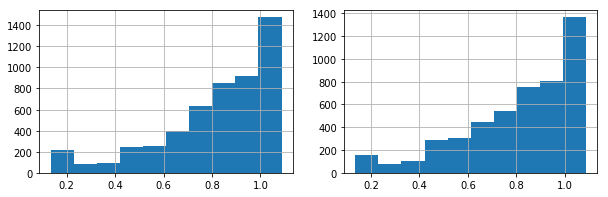

In [72]:
plt.subplot(1,2,1)
(movies['budget']/movies['budget_adj']).hist(figsize=(10,3))
plt.subplot(1,2,2)
(movies['revenue']/movies['revenue_adj']).hist();

根据直方图显示整体上电影成本支出以及票房收入调整的比例分布非常相似

In [73]:
(((movies['revenue']/movies['revenue_adj'])/(movies['budget']/movies['budget_adj'])).max(),
((movies['revenue']/movies['revenue_adj'])/(movies['budget']/movies['budget_adj'])).min())

(1.0000000000000089, 0.9999999999999908)

通过比较成本调整比例以及票房调整比例之间的比值，求出该数值最大值和最小值后发现都近似等于1，可见成本以及收入的调整是完全同比的，因此之后对收益率的分析是通过调整前还是调整后的数据不会有差别。  
**通过本次数据分析主要想要探索的问题有：  
1、每年最受欢迎的电影类别是哪些？   
2、票房高的电影有哪些特点？**

### 字段筛选、数据规整以及缺失数据行删除


紧接上一部分的分析，将数据集进一步规整化  
主要步骤：  
1、将本次数据分析中不会用到的tagline、overview、homepage等字段删除  
2、将日期数据转化为datetime  
3、清除有缺失值的行

In [74]:
movies.drop(['tagline','overview','homepage'],axis=1,inplace=True)
movies['release_date'] = pd.to_datetime(movies['release_date'])

In [75]:
movies = movies[(movies.isnull().sum(axis=1)==0)]

<a id='eda'></a>
## 探索性数据分析


### 每年最受欢迎的电影类别是什么？

In [76]:
# 以每年票房最高5%的电影作为观众最喜爱的电影，先得到每年调整票房的95分位数
level_95_by_year = {year:np.percentile(movies[movies['release_year']==year]['revenue_adj'],95) for year in movies['release_year'].unique()}

In [77]:
# 为每行记录打上是否属于当年最高5%票房电影的标签
movies['is_top_5_percent'] = movies['revenue_adj'] > movies['release_year'].map(level_95_by_year)

In [78]:
GENRES = list(set('|'.join(set(movies['genres'])).title().split('|')))
len(GENRES)

20

所有数据中共有20个不同的电影类别

In [79]:
# 增加独热码列
for genre in GENRES:
    movies[genre]=False

In [80]:
movies[genre].value_counts()

False    8665
Name: War, dtype: int64

In [81]:
# 将电影类别对应到独热码列
for line in movies.index:
    genre_list = movies.loc[line,'genres'].title().split('|')
    for genre in genre_list:
        movies.loc[line,genre] = True

In [82]:
movies[genre].value_counts()

False    7326
True     1339
Name: Horror, dtype: int64

In [83]:
movies['is_top_5_percent'].value_counts()

False    8211
True      454
Name: is_top_5_percent, dtype: int64

In [62]:
# 计算没一年最高5%票房电影中各个类型分布有多少部，并存入temp变量
temp = movies[movies['is_top_5_percent'] == True].groupby('release_year').sum().loc[:,'Adventure':'Tv Movie'].copy()

In [84]:
temp = movies[movies['is_top_5_percent'] == True].copy()

In [85]:
temp

,id,imdb_id,popularity,budget,revenue,original_title,cast,director,keywords,runtime,...,Documentary,Romance,Tv Movie,Foreign,Mystery,Family,Adventure,Comedy,Thriller,War
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,monster|dna|tyrannosaurus rex|velociraptor|island,124,...,False,False,False,False,False,False,True,False,True,False
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,future|chase|post-apocalyptic|dystopia|australia,120,...,False,False,False,False,False,False,True,False,True,False
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,android|spaceship|jedi|space opera|3d,136,...,False,False,False,False,False,False,True,False,False,False
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,car race|speed|revenge|suspense|car,137,...,False,False,False,False,False,False,False,False,True,False
5,281957,tt1663202,9.110700,135000000,532950503,The Revenant,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...,Alejandro GonzÃ¡lez IÃ±Ã¡rritu,father-son relationship|rape|based on novel|mo...,156,...,False,False,False,False,False,False,True,False,True,False
6,87101,tt1340138,8.654359,155000000,440603537,Terminator Genisys,Arnold Schwarzenegger|Jason Clarke|Emilia Clar...,Alan Taylor,saving the world|artificial intelligence|cybor...,125,...,False,False,False,False,False,False,True,False,True,False
7,286217,tt3659388,7.667400,108000000,595380321,The Martian,Matt Damon|Jessica Chastain|Kristen Wiig|Jeff ...,Ridley Scott,based on novel|mars|nasa|isolation|botanist,141,...,False,False,False,False,False,False,True,False,False,False
8,211672,tt2293640,7.404165,74000000,1156730962,Minions,Sandra Bullock|Jon Hamm|Michael Keaton|Allison...,Kyle Balda|Pierre Coffin,assistant|aftercreditsstinger|duringcreditssti...,91,...,False,False,False,False,False,True,True,True,False,False
9,150540,tt2096673,6.326804,175000000,853708609,Inside Out,Amy Poehler|Phyllis Smith|Richard Kind|Bill Ha...,Pete Docter,dream|cartoon|imaginary friend|animation|kid,94,...,False,False,False,False,False,True,False,True,False,False
10,206647,tt2379713,6.200282,245000000,880674609,Spectre,Daniel Craig|Christoph Waltz|LÃ©a Seydoux|Ralp...,Sam Mendes,spy|based on novel|secret agent|sequel|james bond,148,...,False,False,False,False,False,False,True,False,False,False


In [90]:
temp.loc[:,'Adventure':'Tv Movie'].sum()

Series([], dtype: float64)

In [89]:
temp.loc[line,'Adventure':'Tv Movie'].sum()

0

In [88]:
# 得到每一年最受欢迎的电影类型,并计算在5%受欢迎电影中该类别的占比
temp['top'] = ''
temp['top_count'] = ''
for line in temp.index:
    temp.loc[line,'top_ratio'] = temp.loc[line,'Adventure':'Tv Movie'].max()/temp.loc[line,'Adventure':'Tv Movie'].sum()
    temp.loc[line,'top'] = temp.columns[np.argmax(temp.loc[line,'Adventure':'Tv Movie'])[0]]
#     np.argmax(temp.loc[line,'Adventure':'Tv Movie'])
# np.argmax(temp.loc[1960,'Adventure':'Tv Movie'])
result = temp[['top','top_ratio']]
del temp
result


ZeroDivisionError: float division by zero

In [ ]:
result.groupby(['top']).count()

In [ ]:
result['top'].value_counts()

In [ ]:
result['top'].unique()

In [ ]:
# 对于group的数据统一颜色和legend
# 建立图纸
plt.figure(figsize=(20,10))

# 建立color_map对每个bar的颜色进行设定（对应存在color_list)
color = ['slategray','lightcoral','gold','mediumaquamarine','lightskyblue']
color_map = {result['top'].unique()[i]:color[i] for i in range(5)}
color_list = result['top'].map(color_map)

# 因为legend对应的是每次plt
# 所以如果要按照groupby的5个分组设定不同的legend
# 需要将5个分组的内容分别画出来
plt.bar(x=result[result.top == 'Action'].index,height=result[result.top == 'Action']['top_ratio'],
        color='slategray', label = 'Action')
plt.bar(x=result[result.top == 'Adventure'].index,height=result[result.top == 'Adventure']['top_ratio'],
        color='red', label = 'Adventure')
plt.bar(x=result[result.top == 'Horror'].index,height=result[result.top == 'Horror']['top_ratio'], 
        color='yellow', label = 'Horror')
plt.bar(x=result[result.top == 'History'].index,height=result[result.top == 'History']['top_ratio'], 
        color='green', label = 'History')
plt.bar(x=result[result.top == 'Comedy'].index,height=result[result.top == 'Comedy']['top_ratio'], 
        color='blue', label = 'Comedy')

# 增加legend输出
# plt.legend()
# 如果legend小括弧中指定了legend的说明，会覆盖plt中的参数
plt.legend(['Action','Horrow','Testing','Homemake','Free']);

# 参考：
# https://stackoverflow.com/questions/33476401/color-matplotlib-bar-chart-based-on-value
# https://stackoverflow.com/questions/48020667/how-to-add-legend-based-on-color-in-scatterplot-matplotlib
# https://stackoverflow.com/questions/12236566/setting-different-color-for-each-series-in-scatter-plot-on-matplotlib
# https://stackoverflow.com/questions/18973404/setting-different-bar-color-in-matplotlib-python
# https://stackoverflow.com/questions/19184484/how-to-add-group-labels-for-bar-charts-in-matplotlib
# legend官方文档 https://matplotlib.org/users/legend_guide.html

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from itertools import groupby

def test_table():
    data_table = pd.DataFrame({'Room':['Room A']*4 + ['Room B']*4,
                               'Shelf':(['Shelf 1']*2 + ['Shelf 2']*2)*2,
                               'Staple':['Milk','Water','Sugar','Honey','Wheat','Corn','Chicken','Cow'],
                               'Quantity':[10,20,5,6,4,7,2,1],
                               'Ordered':np.random.randint(0,10,8)
                               })
    return data_table

def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table(ax, df):
    ypos = -.1
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1

df = test_table().groupby(['Room','Shelf','Staple']).sum()
fig = plt.figure()
ax = fig.add_subplot(111)
df.plot(kind='bar',stacked=True,ax=fig.gca())
#Below 3 lines remove default labels
labels = ['' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.set_xlabel('')
label_group_bar_table(ax, df)
fig.subplots_adjust(bottom=.1*df.index.nlevels)
plt.show()

以上就是每一年最受欢迎的电影类别，可以看到从始至终Adventure都是观众非常喜爱的一个电影类别。

### 票房高的电影有哪些特点？

In [ ]:
# 以10%的比例来认定票房高的电影
high_revenues = movies[movies['revenue_adj']>=np.percentile(movies['revenue_adj'],90)]
low_revenues = movies[movies['revenue_adj']<np.percentile(movies['revenue_adj'],90)]
plt.subplot(1,2,1)
high_revenues['runtime'].hist(figsize=(18,5))
plt.subplot(1,2,2)
low_revenues['runtime'].hist();


<a id='conclusions'></a>
## 结论

> **提示**：最后，你需要总结自己的调查结果。请确保你了解在探索过程中的局限性。如果尚未进行任何统计检验，不要做出任何统计结论。切记不要根据相关关系贸然推导出因果关系！

> **提示**：如果你对自己的研究成果感到满意，应将其副本保存为 HTML 或 PDF 形式。在导出报告之前请检查一遍，确保报告结构完整，信息连贯。应删除所有类似的“提示”引用段，以保持报告中的简洁度。在提交之前，你还需要查看在课程结尾的项目提交页面中的项目审阅规范。

> 如需将报告导出到工作区，你可以运行下面的代码框。如果正确，会返回代码 0，工作区目录下会生成 .html 文件（单击左上角的 jupyter 图标）。也可以通过 **文件** > **下载为** 子菜单下载 html 报告，然后手动上传到工作区目录。完成之后，可以单击右下角的“提交项目”，来提交你的项目。恭喜你！

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])